# Modelo detección de intención

Desarrollo de modelo de clasificación binaria, se entrenó un modelo que busca clasificar si un mensaje está preguntando o no sobre la ubicación de un centro médico

## Secciones del Notebook:
1. Carga y exploración de datos
2. Pre-procesamiento de datos
3. Entrenamiento de Modelos
4. Evaluación
5. Prueba de BERTO

In [ ]:
!pip install spacy transformers datasets torch accelerate evaluate -q
!python -m spacy download es_core_news_sm -q

In [ ]:
# Importing Libraries
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score,recall_score,f1_score

from nltk.corpus import stopwords
import spacy
import nltk
from imblearn.over_sampling import RandomOverSampler


## Load Data

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train.head()

,text,tag
0,1,OUT
1,1,OUT
2,1,OUT
3,271112,OUT
4,", enviar direccion de atención del medico",DIRECCION


## EDA

<Axes: >

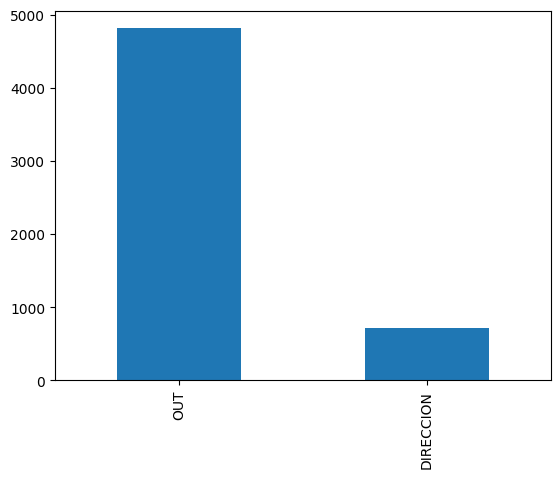

In [ ]:
#Distribution of Classes
train.tag.value_counts().plot(kind='bar')

Se puede apreciar un claro desbalance, esto es importante para considerar como evaluar el modelo y que tecnicas utilizar para manejar esto.

## Pre Processing

In [ ]:
# Initialize spaCy Spanish language model
nlp = spacy.load('es_core_news_sm')

# Download Spanish stopwords from nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
spanish_stopwords = stopwords.words('spanish')

# Function to lemmatize text
def lemmatize_text(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

#Lemmatization
train['text'] = train['text'].apply(lemmatize_text)
test['text'] = test['text'].apply(lemmatize_text)

X = train['text']
y = train['tag']

# Oversampling the minority class
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X.values.reshape(-1, 1), y)

# Convert X_resampled back to text format after resampling
X_resampled_text = [x[0] for x in X_resampled]

In [ ]:
# Text Vectorization using TF-IDF
vectorizer = TfidfVectorizer(stop_words=spanish_stopwords, max_features=1000)
X_train = vectorizer.fit_transform(X_resampled_text)
y_train = y_resampled

X_test = vectorizer.transform(test['text'])  # Transform the test data using the same vectorizer


## Model Training

In [ ]:
# Model training with Logistic Regression
lr_model = LogisticRegression(solver='liblinear')
lr_model.fit(X_train, y_train)

# Model training with Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

## Evaluation

In [ ]:
#Making Predictions with Logistic Regression
lr_predictions = lr_model.predict(X_test)

print('Logistic Regression')
print("Precison:", precision_score(test['tag'], lr_predictions,pos_label='DIRECCION'))
print("Recall:",recall_score(test['tag'], lr_predictions,pos_label='DIRECCION'))
print("F1 Score:", f1_score(test['tag'], lr_predictions,pos_label='DIRECCION'))

#Making Predictions with Random Forest
rf_predictions = rf_model.predict(X_test)

print('Random Forest')
print("Precison:", precision_score(test['tag'], rf_predictions,pos_label='DIRECCION'))
print("Recall:",recall_score(test['tag'], rf_predictions,pos_label='DIRECCION'))
print("F1 Score:", f1_score(test['tag'], rf_predictions,pos_label='DIRECCION'))

Logistic Regression
Precison: 0.7708333333333334
Recall: 0.9367088607594937
F1 Score: 0.8457142857142858
Random Forest
Precison: 0.8414634146341463
Recall: 0.8734177215189873
F1 Score: 0.857142857142857


# Conclusion

Las clasificaciones son razonablemente buenas, escogí las metricas de precision, recall y F1 score debido a que se centran en la exactitud e integridad de las predicciones para la clase minoritaria. Dependiendo de las necesidades del negocio se puede determinar que metrica es más importante entre Precision y Recall.

Siguientes Mejoras pueden incluir:
- Incluir mayor pre processing de la data
- Optimización de hiperparámetros
- Validación cruzada
- Hacer entrenamiento de modelos más complejos
- Realizar Metodos de Ensamblaje (Combinar modelos)

## Fine Tuning BERTO (Considering GPU)

In [ ]:
import pandas as pd
from datasets import Dataset

from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding

import evaluate
import numpy as np


### Pre Process

In [ ]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

#Changing Column names and labels to match the expected Training values
train_df.rename(columns={'tag': 'label'}, inplace=True)
test_df.rename(columns={'tag': 'label'}, inplace=True)

train_df['label'] = train_df['label'].map({'DIRECCION': 1, 'OUT': 0})
test_df['label'] = test_df['label'].map({'DIRECCION': 1, 'OUT': 0})

# Convert DataFrames to Hugging Face Dataset objects
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

In [ ]:

# Loading Tokenizer
tokenizer = AutoTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True,max_length=512)

# Pre processing text
tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/5525 [00:00<?, ? examples/s]

Map:   0%|          | 0/828 [00:00<?, ? examples/s]

### Training

In [ ]:
# Loading BERTO Moedel

label_to_index = {"OUT": 0, "DIRECCION": 1}
index_to_label = {0:"OUT",1:"DIRECCION"}  # For converting back to string labels

model = AutoModelForSequenceClassification.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased", num_labels=2, id2label=index_to_label, label2id=label_to_index)

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
f1_score = evaluate.load("f1")
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return f1_score.compute(predictions=predictions, references=labels)

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir="results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,No log,0.213233,0.869048
2,0.022500,0.151859,0.894410


Checkpoint destination directory results/checkpoint-346 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory results/checkpoint-692 already exists and is non-empty.Saving will proceed but saved results may be invalid.


TrainOutput(global_step=692, training_loss=0.02256191534803093, metrics={'train_runtime': 1087.8448, 'train_samples_per_second': 10.158, 'train_steps_per_second': 0.636, 'total_flos': 2907377161728000.0, 'train_loss': 0.02256191534803093, 'epoch': 2.0})